In [2]:
## Loading libs:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as  np
from scipy import signal
import scipy
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from ipywidgets import interactive
from IPython.display import HTML
import math
import datetime
from matplotlib import animation
import pickle
##load the csv file containing the data
data_path = "..\\Datasets\\Forecasting_aqua\\ctd_meteo_aua_2019to2021_V2.csv"
df = pd.read_csv(data_path)

#make the date a date object
format = "%d-%m-%Y"
time_df = pd.to_datetime(df["Datetime"], format=format)
df['Datetime']= time_df

#drop a useless column
df.drop("sample",axis=1,inplace=True,errors='ignore')

#add year, month and day from datetime
df['year'] = df['Datetime'].dt.year
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day


#prepare the tickslabels
years = df['year'].unique()
months=[]
fday = []
for day in range(1,366):
    dstr = str(day)
    date = datetime.datetime.strptime("2019-" + dstr, "%Y-%j")
    months.append(date.strftime("%b"))
months,fday = np.unique(months,return_index=True)
#note that the months are not in order, but the ticks are still correct


print("You have now loaded the libraries and the data")


You have now loaded the libraries and the data


In [29]:
taxa_keys = ['asplanchna', 'asterionella', 'brachionus', 'diatom_chain', 'dinobryon',
       'eudiaptomus', 'kellikottia', 'keratella_quadrata', 'nauplius',
       'polyarthra', 'rotifers', 'synchaeta', 'ceratium', 'cyclops',
       'fragilaria', 'keratella_cochlearis', 'paradileptus', 'bosmina',
       'daphnia', 'trichocerca', 'conochilus', 'diaphanosoma', 'uroglena',
       'leptodora', 'chaoborus', 'aphanizomenon','diatom','ciliate']
cluster_keys = ['cluster_1', 'cluster_2','cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7',
               'cluster_8']
water_keys = ['mean_temp', 'cv_temp_day','cv_temp_depth', 'mean_condF', 'cv_condF_day', 'cv_condF_depth',
       'mean_o2', 'cv_o2_day', 'cv_o2_depth', 'mean_o2ppm', 'cv_o2ppm_day',
       'cv_o2ppm_depth', 'mean_ph', 'cv_ph_day', 'cv_ph_depth', 'mean_chla',
       'cv_chla_day', 'cv_chla_depth', 'mean_turb', 'cv_turb_day',
       'cv_turb_depth', 'mean_par', 'cv_par_day', 'cv_par_depth']
meteo_keys = ['mean_cloud_cover', 'mean_global_radiation', 'atmospheric_pressure_max',
       'atmospheric_pressure_min', 'atmospheric_pressure_mean', 'temp_max',
       'temp_min', 'temp_mean', 'precipitation_tot', 'rel_air_humidity_max',
       'rel_air_humidity_min', 'rel_air_humidity_mean', 'sunshine_duration',
       'windspeed_mean', 'windspeed_max', 'wind_direction_mean']
nut_keys = ['Nitrat','Nitrit', 'Ammonium', 'oP', 'TP', 'TN',]
phys_keys = ['mean_thermocline_depth',
       'cv_thermo', 'mean_schmidt', 'cv_schmidt', 'mean_epi_temp',
       'cv_epi_temp', 'mean_mixed_layer_depth', 'cv_mixed_layer_depth',
       'ml_irradiance', 'mean_oxycline_depth', 'cv_oxycline_depth']
temporal_key = ['year','month', 'day']

In [449]:
#interpolate
dfi = df.interpolate(method='ffill', axis=0)
#the following columns were not used during the whole duration of the experiment
dfi.drop(columns=['mean_phy','cv_phy_day','cv_phy_depth','mean_phycoer','cv_phycoer_day',
                  'cv_phycoer_depth','TOC'],
         inplace=True,errors='ignore')
#only use valid values
dfi.dropna(inplace=True)
dfi.reset_index(inplace=True,drop=True)
dfi.drop(columns=['Datetime'],inplace=True, errors='ignore')

In [614]:
#shorten the dataset:
dfs = dfi[30:120]
dfs = dfs[taxa_keys]

In [615]:
dfs

,asplanchna,asterionella,brachionus,diatom_chain,dinobryon,eudiaptomus,kellikottia,keratella_quadrata,nauplius,polyarthra,...,daphnia,trichocerca,conochilus,diaphanosoma,uroglena,leptodora,chaoborus,aphanizomenon,diatom,ciliate
30,0.000972,0.000972,0.003194,0.001250,0.009375,0.010625,0.004444,0.000625,0.051597,0.000486,...,0.003264,0.000208,0.004514,0.000000,0.000278,0.000000,0.000000,0.000764,0.011667,0.001061
31,0.000347,0.001389,0.001528,0.001528,0.008125,0.007083,0.002639,0.000278,0.041667,0.000208,...,0.006319,0.000208,0.003542,0.000139,0.000139,0.000000,0.000139,0.000764,0.015217,0.002246
32,0.000556,0.000625,0.001319,0.001319,0.005625,0.012014,0.003125,0.000625,0.040347,0.000556,...,0.002639,0.000347,0.003125,0.000069,0.000278,0.000000,0.000000,0.000347,0.015556,0.002500
33,0.000486,0.000694,0.000833,0.001042,0.003125,0.018542,0.004028,0.000625,0.041944,0.000069,...,0.008611,0.000347,0.004236,0.000208,0.000208,0.000139,0.000000,0.000278,0.013478,0.002536
34,0.000625,0.000694,0.001319,0.000486,0.002222,0.011389,0.005278,0.000278,0.047917,0.000278,...,0.002917,0.000208,0.005208,0.000208,0.000139,0.000069,0.000000,0.000556,0.016232,0.002536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.000000,0.000000,0.000000,0.000000,0.011667,0.000000,0.000000,0.001667,0.003333,0.000000,...,0.000000,0.001667,0.000000,0.000000,0.001667,0.000000,0.000000,0.000000,0.000556,0.001111
116,0.000000,0.000000,0.000000,0.000000,0.121667,0.006667,0.000000,0.000000,0.005000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.005079,0.003651
117,0.000000,0.000000,0.000000,0.000000,0.121667,0.006667,0.000000,0.000000,0.005000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.003167,0.005333
118,0.000530,0.000455,0.003333,0.000152,0.586515,0.007803,0.000833,0.002955,0.026288,0.000227,...,0.005833,0.004394,0.000152,0.004091,0.092273,0.000152,0.000076,0.001136,0.005526,0.008158


In [616]:
#define the function:
def windowed_cor(df,key1,key2,window_size,max_lag,epsilon=0.00000000001):
    cor = np.zeros((max_lag,len(df)-window_size-max_lag))
    dfd = df.drop('Datetime',axis=1,errors='ignore')
    for start in range(len(df)-window_size-max_lag):
        for lag in range(max_lag):
            input1=dfd[key1][start:start+window_size]
            input1.interpolate(method='linear', limit_direction='forward', axis=0)
            input1=input1-input1.mean()
            input1.reset_index(drop=True,inplace=True)
            input2=dfd[key2][start+lag:start+window_size+lag]
            input2.interpolate(method='linear', limit_direction='forward', axis=0)
            input2=input2-input2.mean()
            input2.reset_index(drop=True,inplace=True)
            
            cor[lag,start] =(input1*input2).mean()/(input1.std()*input2.std()+epsilon)
    return cor


In [617]:
#test the function
cor = windowed_cor(dfs,'nauplius','nauplius',30,1)

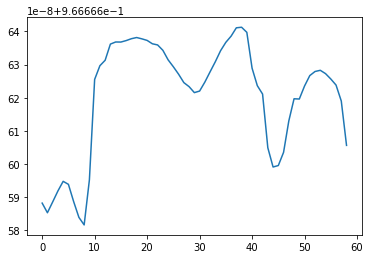

In [618]:
plt.plot(cor[0])

In [619]:
#build the time dependant correlation array:
window = 60
cor_a = np.zeros((len(dfs.keys()),len(dfs.keys()),len(dfs)-window-1))
for idx1,key1 in enumerate(dfs.keys()):
    print(f"{idx1}/{len(dfs.keys())}",end='\r')
    for idx2,key2 in enumerate(dfs.keys()[idx1:]):
        idx2+=idx1
        cor_a[idx1,idx2,:]=np.squeeze(windowed_cor(dfs,key1,key2,window,1))
        

In [620]:
#fill the missing values
cor_af = cor_a + np.transpose(cor_a, axes=[1,0,2])
for i in range(cor_af.shape[0]):
    cor_af[i,i,:]=cor_af[i,i,:]/2

In [621]:
#for now, focus only on one month of the time serie:
start_date = 28
cor = cor_af[:,:,start_date]

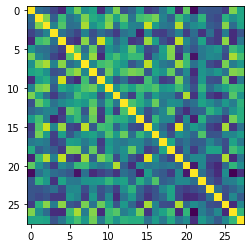

In [622]:
plt.imshow(cor)

In [623]:

#compute the partial corelation
def part_cor(cor):
    size = cor.shape[0]
    par_cor = np.zeros((size,size,size))
    icor2 = 1-np.square(cor)
    for i in range(size):
        par_cor[i,:,:]=np.array([(cor[i,k]-cor[k,:]*cor[i,:])/(icor2[i,:]*icor2[k,:]) for k in range(size)])
    return par_cor

par_cor = part_cor(cor)

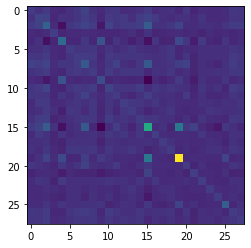

In [624]:
plt.imshow(par_cor[:,:,19])

In [625]:
par_cor[0,0,0]

14.9981003424533

In [626]:
d = np.repeat(np.expand_dims(cor,-1),cor.shape[0],axis=2)-par_cor

In [627]:
size = d.shape[0]
D = np.sum(d,axis=1)
for j in range(size):
    D[:,j] -= d[:,j,j] 
D/=(d.shape[0]-1)

In [628]:
th = 0.15
Df = np.copy(D)
Df[np.abs(D)<th]=0

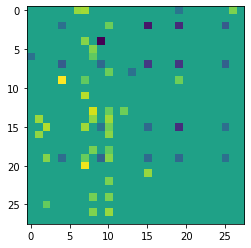

In [631]:
plt.imshow(Df)

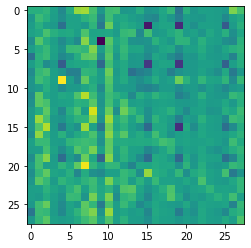

In [632]:
#normalize D:
Dn = (D-np.min(D))/(np.max(D)-np.min(D))
plt.imshow(Dn)

In [633]:
min_tree = scipy.sparse.csgraph.minimum_spanning_tree(Dn, overwrite=False)

In [634]:
mta = min_tree.toarray()

In [635]:
mta.shape

(28, 28)

In [25]:
from pyvis.network import Network
import networkx as nx

import matplotlib.pyplot as plt

In [637]:
net = Network(notebook=True,height='600px', width='800px', bgcolor='#222222', font_color='white',
              directed=False,layout=False)
net.barnes_hut()
for idx,key in enumerate(dfs.keys()):
    if key in taxa_keys:
        color = 'lime'
    elif key in cluster_keys: 
        color = 'green'
    elif key in water_keys:
        color = 'blue'
    elif key in meteo_keys:
        color = 'cyan'
    elif key in nut_keys:
        color = 'red'
    elif key in phys_keys:
        color = 'yellow'
    else:
        color = 'purple'
    net.add_node(idx, label=key, shape='dot',color=color)
for idx1 in range(D.shape[0]):
    for idx2 in range(D.shape[0]):
        if mta[idx1,idx2] != 0:
            net.add_edge(idx1,idx2,width=15*mta[idx1,idx2])

In [639]:
net = Network(height='600px', width='800px', bgcolor='#FFFFFF', font_color='black',
              directed=True,layout=False)
net.barnes_hut()
for idx,key in enumerate(dfs.keys()):
    if key in taxa_keys:
        color = 'lime'
    elif key in cluster_keys: 
        color = 'green'
    elif key in water_keys:
        color = 'blue'
    elif key in meteo_keys:
        color = 'cyan'
    elif key in nut_keys:
        color = 'red'
    elif key in phys_keys:
        color = 'yellow'
    else:
        color = 'purple'
    net.add_node(idx, label=key, shape='dot',color=color)
for idx1 in range(D.shape[0]):
    for idx2 in range(D.shape[0]):
        if idx1 != idx2 and Df[idx1,idx2] != 0:
            if Df[idx1,idx2]<0:
                net.add_edge(idx2,idx1,width=15*np.abs(Df[idx1,idx2]),color='red')
            else:
                net.add_edge(idx2,idx1,width=15*np.abs(Df[idx1,idx2]),color='blue')

In [640]:
net.prep_notebook()
net.show("test.html")

In [522]:
net.show_buttons()

The graph seems to be relevant, so it is average over the whole time series to get meaningful connection

In [641]:
dfs = dfi

In [648]:
#build the time dependant correlation array:
window = 90#len(dfs)-2
cor_a = np.zeros((len(dfs.keys()),len(dfs.keys()),len(dfs)-window-1))

for idx1,key1 in enumerate(dfs.keys()):
    print(f"{idx1+1}/{len(dfs.keys())}",end='\r')
    for idx2,key2 in enumerate(dfs.keys()[idx1:]):
        idx2+=idx1
        cor_a[idx1,idx2,:]=np.squeeze(windowed_cor(dfs,key1,key2,window,1))

In [649]:
#fill the missing values
cor_af = cor_a + np.transpose(cor_a, axes=[1,0,2])
for i in range(cor_af.shape[0]):
    cor_af[i,i,:]=cor_af[i,i,:]/2

In [650]:
par_cor = np.zeros((cor_af.shape[0],cor_af.shape[0],cor_af.shape[0],cor_af.shape[2]))
for start_date in range(cor_af.shape[2]):
    cor = cor_af[:,:,start_date]
    par_cor[:,:,:,start_date] = part_cor(cor)

In [653]:
par_cor.shape

(96, 96, 96, 899)

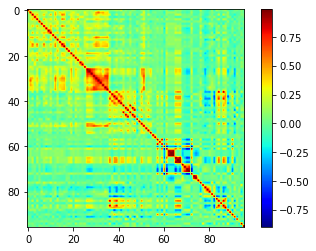

In [652]:
plt.imshow(np.mean(cor_af,axis=2),cmap='jet')
plt.colorbar()

In [654]:
d = np.repeat(np.expand_dims(cor_af,1),cor_af.shape[0],axis=1)-par_cor

In [655]:
d.shape

(96, 96, 96, 899)

In [656]:
size = d.shape[0]
D = np.sum(d,axis=1)
for j in range(size):
    D[:,j] -= d[:,j,j] 
D/=(d.shape[0]-1)

In [657]:
D.shape

(96, 96, 899)

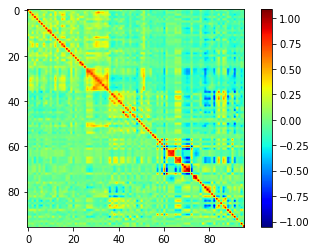

In [659]:
plt.imshow(np.mean(D,axis=2),cmap='jet')
plt.colorbar()

In [660]:
Dm = np.mean(D,axis=-1)

In [738]:
th = 0.45
Df = np.copy(Dm)
Df[np.abs(Dm)<th]=0

In [741]:
net = Network(height='600px', width='800px', bgcolor='#FFFFFF', font_color='black',
              directed=True,layout=False)
net.barnes_hut()
for idx,key in enumerate(dfs.keys()):
    if key in taxa_keys:
        color = 'lime'
    elif key in cluster_keys: 
        color = 'green'
    elif key in water_keys:
        color = 'blue'
    elif key in meteo_keys:
        color = 'cyan'
    elif key in nut_keys:
        color = 'red'
    elif key in phys_keys:
        color = 'yellow'
    else:
        color = 'purple'
    net.add_node(idx, label=key, shape='dot',color=color,size=75)
    net.nodes[-1]['font']['size']=75
for idx1 in range(D.shape[0]):
    for idx2 in range(D.shape[0]):
        if idx1 != idx2 and Df[idx1,idx2] != 0:
            if Df[idx1,idx2]<0:
                net.add_edge(idx2,idx1,width=15*np.abs(Df[idx1,idx2]),color='red')
            else:
                net.add_edge(idx2,idx1,width=15*np.abs(Df[idx1,idx2]),color='blue')

In [801]:
net.prep_notebook()
net.show("threshold_045.html")

In [764]:
net.show_buttons()

In [817]:
size = Dm.shape[0]
edges=[]
for idx1 in range(size):
    for idx2 in range(size):
        if idx1 != idx2:
            edge = {'source': dfs.keys()[idx2], 'sink':dfs.keys()[idx1], 'weight':Dm[idx1,idx2]}
            edges.append(edge)

In [853]:
sorted_edges = sorted(edges,key= lambda x: np.abs(x['weight']),reverse=True)

In [854]:
sorted_edges

[{'source': 'mean_o2', 'sink': 'mean_o2ppm', 'weight': 1.06764074613528},
 {'source': 'mean_cloud_cover',
  'sink': 'sunshine_duration',
  'weight': -1.0509715473882566},
 {'source': 'mean_global_radiation',
  'sink': 'sunshine_duration',
  'weight': 1.0161190655355816},
 {'source': 'mean_cloud_cover',
  'sink': 'mean_global_radiation',
  'weight': -0.980947401344443},
 {'source': 'rel_air_humidity_min',
  'sink': 'mean_global_radiation',
  'weight': -0.980752753580405},
 {'source': 'rel_air_humidity_mean',
  'sink': 'rel_air_humidity_min',
  'weight': 0.9765310377333141},
 {'source': 'sunshine_duration',
  'sink': 'mean_cloud_cover',
  'weight': -0.9562538090693795},
 {'source': 'atmospheric_pressure_mean',
  'sink': 'atmospheric_pressure_max',
  'weight': 0.9096762634181069},
 {'source': 'cv_par_depth', 'sink': 'mean_par', 'weight': 0.8968047202784009},
 {'source': 'rel_air_humidity_mean',
  'sink': 'mean_global_radiation',
  'weight': -0.8922893496145807},
 {'source': 'rel_air_humid

In [19]:
def build_PMFG(sorted_edges, nb_nodes):
    PMFG = nx.Graph()
    for edge in sorted_edges:
        if edge['weight']<0:
            PMFG.add_edge(edge['source'], edge['sink'],weight=-15*edge['weight'],color='red')
        else:
            PMFG.add_edge(edge['source'], edge['sink'],weight= 15*edge['weight'],color='blue')
        planar,_ = nx.check_planarity(PMFG, counterexample=False)
        if not planar:
            PMFG.remove_edge(edge['source'], edge['sink'])
            
        if len(PMFG.edges()) == 3*(nb_nodes-2):
            break
    
    return PMFG
PMFG = build_PMFG(sorted_edges,size)

NameError: name 'nx' is not defined

In [868]:
PMFG
PMFG_disp = Network(height='600px', width='800px', bgcolor='#FFFFFF', font_color='black',
                      directed=True,layout=False)
PMFG_disp.from_nx(PMFG)


In [869]:
for node in PMFG_disp.nodes:
    key = node['id']
    if key in taxa_keys:
        color = 'lime'
    elif key in cluster_keys: 
        color = 'green'
    elif key in water_keys:
        color = 'blue'
    elif key in meteo_keys:
        color = 'cyan'
    elif key in nut_keys:
        color = 'red'
    elif key in phys_keys:
        color = 'yellow'
    else:
        color = 'purple'
    node['color']=color

In [870]:
#PMFG_disp.show_buttons()
PMFG_disp.show('PMFG.html')

# Attention Matrix

In [13]:
#load the adjacency matrix:
file_att = 'adj_att.pickle'
with open(file_att, 'rb') as f:
    adj= pickle.load(f)
file_name = 'name.pickle'
with open(file_name, 'rb') as f:
    names = pickle.load(f)

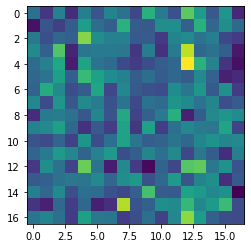

In [12]:
plt.imshow(adj)

In [15]:
size = adj.shape[0]
edges=[]
for idx1 in range(size):
    for idx2 in range(size):
        if idx1 != idx2:
            edge = {'source': names[idx1], 'sink':names[idx2], 'weight':adj[idx1,idx2]}
            edges.append(edge)

In [17]:
sorted_edges = sorted(edges,key= lambda x: np.abs(x['weight']),reverse=True)

In [26]:
PMFG = build_PMFG(sorted_edges,size)

In [27]:
PMFG
PMFG_disp = Network(height='600px', width='800px', bgcolor='#FFFFFF', font_color='black',
                      directed=True,layout=False)
PMFG_disp.from_nx(PMFG)

In [31]:
for node in PMFG_disp.nodes:
    key = node['id']
    if key in taxa_keys:
        color = 'lime'
    elif key in cluster_keys: 
        color = 'green'
    elif key in water_keys:
        color = 'blue'
    elif key in meteo_keys:
        color = 'cyan'
    elif key in nut_keys:
        color = 'red'
    elif key in phys_keys:
        color = 'yellow'
    else:
        color = 'purple'
    node['color']=color

In [32]:
PMFG_disp.show('PMFG_att.html')